In [ ]:
!pip install tensorflow-probability
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ielmmec4
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ielmmec4
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=6afb3c902b31cd77eaa4b5d359a429fe4fa9b21e1c154676633ca698edd24979
  Stored in directory: /tmp/pip-ephem-wheel-cache-qpzsekez/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [ ]:
from IPython import display
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

# [5월 17일]
---

## # 이미지 생성 모델
---
- 이미지 잠재 공간에서 샘플링하여 완전히 새로운 이미지나 기존 이미지를 변형시키는 방식의 주요 기법
  - 변이형 오토인코더(Variational AutoEncoders, VAE)
  
  - 적대적 생성 네트워크(Generative Adversarial Networks, GAN)

- 잠재 공간의 한 포인트를 입력으로 받아 이미지(픽셀의 그리드)를 출력하는 모듈을 VAE에서는 디코더(decoder)라고 함

- 수학적으로 AutoEncoder와 Variational AutoEncoder는 전혀 관계가 없다.
AutoEncoder의 목적은 Manifold Learning인 반면 Variational AutoEncoder는 Generative Model이다. 공교롭게도 그 구조를 보니 AE와 같은 것일 뿐임.
매니폴드는 고차원의 데이터, 즉, training DB의 데이터 그 자체를 error없이 잘 표현하는 subspace를 의미
$$$$

### # 잠재 공간(Latent Space)
---
<img src="https://images.deepai.org/converted-papers/2007.08383/x1.png">

<sub>[이미지 출처] https://deepai.org/publication/deep-learning-in-protein-structural-modeling-and-design</sub>
$$$$

### # 변이형 오토인코더(Variational AutoEncoders, VAE)
---
VAE란 : https://process-mining.tistory.com/161


- 입력 이미지를 잠재 공간의 고정된 코딩으로 압축하는 대신  
  이미지를 어떤 통계 분포의 파라미터로 변환 
  
- 평균과 분산 파라미터를 사용하여 이 분포에서 무작위로 하나의 샘플을 추출

- 해당 샘플을 디코딩하여 원본 입력으로 복원

- 위 과정은 안정성을 향상, 잠재 공간 어디에서든 의미있는 표현을 인코딩하게 함

  <img src="https://image.slidesharecdn.com/variationalautoencoder-170601084514/95/variational-autoencoder-21-638.jpg?cb=1496306885">

  <sub>[이미지 출력] https://www.slideshare.net/ssuser06e0c5/variational-autoencoder-76552518</sub>

  <br>

- VAE의 훈련

  - 디코딩된 샘플이 원본 입력과 동일하도록 만드는 재구성 손실(reconstruction loss)

  - 잠재 공간을 잘 형성하고 훈련 데이터에 과적합을 줄이는 규제 손실(regularization loss)

- VAE 구현의 pseudocode

      z_mean, z_log_var = encoder(input_img)
      
      z = z_mean + exp(0.5 * z_log_var) * epsilon

      recontructed_img = decoder(z)

      model = Model(input_img, reconstructed_img)

      재구성 손실과 규제 손실을 사용하여 훈련
$$$$

### # 손실 함수 및 최적화 프로그램 정의
---
- VAE는 한계 로그 우도에서 증거 하한 (ELBO)을 최대화하여 학습<br>
우리가 원하는 것은 log(p(x)) 값의 최적화이기 때문에 EBLO(Φ) + KL에서 ELBO(Φ)의 값을 최적화

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

- 실제로 우리는이 기대치의 단일 샘플 Monte Carlo 추정치를 최적화

$$\log p(x| z) + \log p(z) - \log q(z|x),$$

몬테카를로 시뮬레이션이란 알려지지 않은 값을 추론적 통계(inferential statistics)방법을 이용해 추정하는 것을 의미합니다. 추론적 통계에서 중요한 개념은 모집단(population)과 샘플(sample)입니다.


## # 변이형 오토인코더
---
- 참고 :  
https://www.tensorflow.org/tutorials/generative/cvae?hl=ko  
https://bnmy6581.tistory.com/23

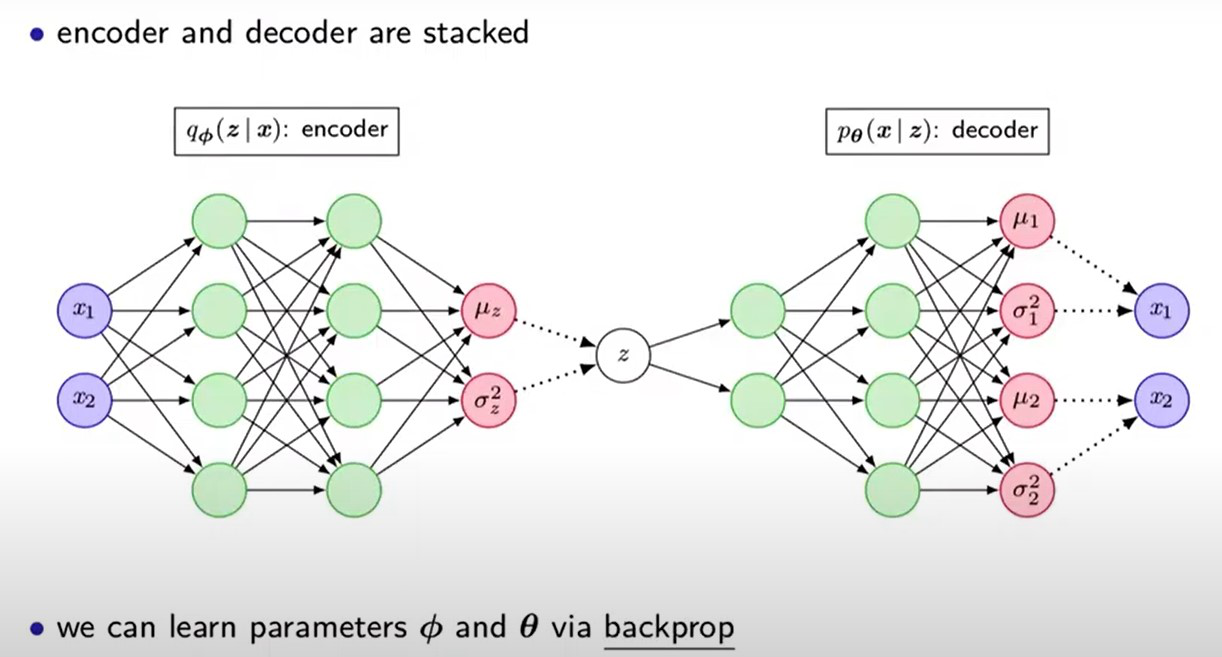

In [ ]:
import PIL.Image as pil

img_path = '/content/drive/MyDrive/workspace/cakd5/m10_딥러닝 응용/고급 이미지 처리/vae_architecture.jpg'
img = pil.open(img_path)
img

### # 인코더 및 디코더 네트워크 정의
---
이 VAE 예제에서는 인코더 및 디코더 네트워크에 두 개의 작은 ConvNet을 사용합니다. 문헌에서, 이들 네트워크는 각각 추론/인식 및 생성 모델로도 지칭됩니다. 구현을 단순화하기 위해 tf.keras.Sequential을 사용합니다. 다음 설명에서  및 는 각각 관측 값과 잠재 변수를 나타냅니다.
$$$$

인코더 네트워크
- 이것은 근사 사후 분포 를 정의합니다. 이 분포는 관측 값을 입력으로 받고 잠재 표현 의 조건부 분포를 지정하기 위한 매개변수 세트를 출력합니다. 이 예에서는 분포를 대각선 가우스로 간단히 모델링하고 네트워크는 인수 분해된 가우스의 평균 및 로그-분산 매개변수를 출력합니다. 수치 안정성을 위해 분산을 직접 출력하지 않고 로그-분산을 출력합니다.
$$$$

디코더 네트워크
- 잠재 샘플 를 입력으로 사용하여 관측 값의 조건부 분포에 대한 매개변수를 출력하는 관측 값 의 조건부 분포를 정의합니다. 잠재 이전 분포 를 단위 가우스로 모델링합니다.
$$$$

재매개변수화 트릭
- 훈련 중에 디코더에 대해 샘플 를 생성하기 위해, 입력 관측 값 가 주어졌을 때 인코더에 의해 출력된 매개변수로 정의된 잠재 분포로부터 샘플링할 수 있습니다. 그러나 역전파가 무작위 노드를 통해 흐를 수 없기 때문에 이 샘플링 작업에서 병목 현상이 발생합니다.
이를 해결하기 위해 재매개변수화 트릭을 사용합니다. 이 예에서는 디코더 매개변수와 다른 매개변수 을 다음과 같이 사용하여 를 근사시킵니다.
여기서  및 는 각각 가우스 분포의 평균 및 표준 편차를 나타냅니다. 이들은 디코더 출력에서 파생될 수 있습니다. 은 의 무질서도를 유지하는 데 사용되는 무작위 노이즈로 생각할 수 있습니다. 표준 정규 분포에서 을 생성합니다.
잠재 변수 는 이제 ,  및 의 함수에 의해 생성되며, 이를 통해 모델은 각각  및 를 통해 인코더의 그래디언트를 역전파하면서 를 통해 무질서도를 유지할 수 있습니다.
$$$$

네트워크 아키텍처
- 인코더 네트워크의 경우 두 개의 컨볼루션 레이어, 그리고 이어서 완전히 연결된 레이어를 사용합니다. 디코더 네트워크에서 완전히 연결된 레이어와 그 뒤에 세 개의 컨볼루션 전치 레이어(일부 컨텍스트에서는 디컨볼루션 레이어라고도 함)를 사용하여 이 아키텍처를 미러링합니다. 미니 배치 사용으로 인한 추가 무질서도가 샘플링의 무질서에 더해 불안정성을 높일 수 있으므로 VAE 훈련시 배치 정규화를 사용하지 않는 것이 일반적입니다.

In [ ]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
                                            tf.keras.layers.InputLayer(input_shape = (28, 28, 1)),
                                            tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = (2, 2), activation = 'relu'),
                                            tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = (2, 2), activation = 'relu'),
                                            tf.keras.layers.Flatten(),
                                            tf.keras.layers.Dense(latent_dim + latent_dim)
                                            ])
        
        self.decoder = tf.keras.Sequential([
                                            tf.keras.layers.InputLayer(input_shape = (latent_dim,)),
                                            tf.keras.layers.Dense(units = 7 * 7 * 32, activation = tf.nn.relu),
                                            tf.keras.layers.Reshape(target_shape = (7, 7, 32)),
                                            tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu'),
                                            tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu'),
                                            tf.keras.layers.Conv2DTranspose(filters = 1, kernel_size = 3, strides = 1, padding = 'same')
                                            ])

    @tf.function
    def sample(self, eps = None):
        if eps is None:
            eps = tf.random.normal(shape = (100, self.latent_dim))
        return self.decode(eps, apply_sigmoid = True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits = 2, axis = 1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape = mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid = False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [ ]:
cvae = CVAE(2)
cvae.encoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 13, 13, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 flatten_2 (Flatten)         (None, 2304)              0         
                                                                 
 dense_4 (Dense)             (None, 4)                 9220      
                                                                 
Total params: 28,036
Trainable params: 28,036
Non-trainable params: 0
_________________________________________________________________


### # 손실 함수 및 옵티마이저 정의
---

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)

# 확률밀도함수 구하는 사용자함수
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):

  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

### # MNIST 데이터 로드
---

In [ ]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [ ]:
# 데이터 이진화
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return images.astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)


# 데이터 배치 및 셔플
train_size = 60000
test_size = 10000
batch_size = 32

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size))

### # 모델 훈련 및 이미지 생성
---

In [ ]:
epochs = 10
latent_dim = 2
num_examples_to_generate = 16

random_vector_for_generation = tf.random.normal(shape = [num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize = (4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap = 'gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -159.4809112548828, time elapse for current epoch: 4.625667095184326


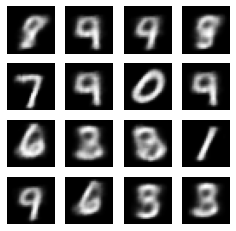

In [ ]:
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait = False)
    print(f'Epoch: {epoch}, Test set ELBO: {elbo}, time elapse for current epoch: {end_time - start_time}')
    generate_and_save_images(model, epoch, test_sample)

### # 마지막 훈련 epoch에서 생성된 이미지 표시
---

(-0.5, 287.5, 287.5, -0.5)

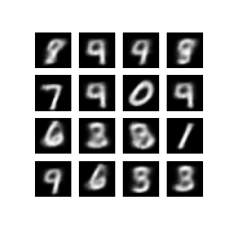

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

plt.imshow(display_image(epoch))
plt.axis('off')

### # 저장된 모든 이미지의 애니메이션 GIF 표시
---


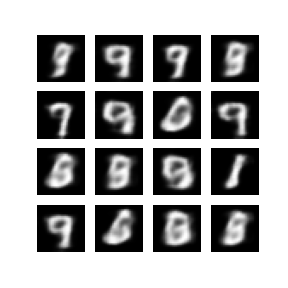

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode = 'I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)